In [8]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [9]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.7
Uninstalling nltk-3.7:
  Successfully uninstalled nltk-3.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00a 0:00:01


In [10]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [11]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import pyspark 
#sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '32g')])
# here you stop the old spark context with old conf
sc.stop()


Original spark.driver.maxResultSize: 1920m


In [13]:
sc = pyspark.SparkContext(conf=conf)
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
 

22/11/18 05:24:59 WARN org.apache.spark.SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69

New spark.driver.maxResultSize: 32g


In [14]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [15]:
news = spark.read.parquet('gs://msca-bdp-data-open/news_similar/')

#### In order to run the text test successfully, I sampled the dataset with 10000 observations

In [16]:
news = news.limit(10000)

In [17]:
news.limit(5)

url,date,language,title,text
http://idrw.org/g...,2021-01-26,en,Govt to continue ...,Govt to continue ...
http://usweekly.c...,2021-06-03,en,TikTok bee-f? Tik...,TikTok bee-f? Tik...
https://7news.com...,2021-11-15,en,Woolworths superm...,Woolworths superm...
https://7news.com...,2021-05-10,en,TikTok influencer...,TikTok influencer...
https://7news.com...,2021-07-19,en,‘TikTok guy’ Jon-...,‘TikTok guy’ Jon-...


# Assess Similarity by Text

In [18]:
text_df = news.select('text',substring('text',1,300)).withColumnRenamed("substring(text, 1, 300)","trimmed_text")
text_df.limit(5)  

text,trimmed_text
TikTok has no she...,TikTok has no she...
TikTok video pro...,TikTok video pro...
Johnny Depp’s new...,Johnny Depp’s new...
TikTok user claim...,TikTok user claim...
Tiktok lovers Car...,Tiktok lovers Car...


In [19]:
body_text = text_df.rdd.map(lambda x : x['trimmed_text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [20]:
row = Row('text')
text_df=body_text.map(row).zipWithIndex().toDF(['trimmed_text','id'])
text_df.limit(5)

trimmed_text,id
{The Daily Ripple...,0
{Dr Pepper Tuitio...,1
{Angry rant from ...,2
"{Amid Ban, Tiktok...",3
{TikTok User Shar...,4


In [21]:
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [22]:
text_df.count() 

10000

In [23]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[local, police, on, alert, in, wake, of, alleged, ‘tiktok’, school, violence, campaign, reading, homenewshere.comyou, have, permission, to, edit, this, article., editclosewelcome,, guestsign, up, log, in, dashboard, logoutmy, accountmy, account, dashboard, profile, saved, items, logouth]",0
1,"[biden, revokes, trump's, ban, on, chinese, apps, tiktok,, wechat;, orders, 'criteria-based, decision', indian, defence, newshomeindiaall, indian, defence, newsarmyair, forcenavychief, of, defence, staffaksai, chinartificial, intelligenceanti-satellite, missilearticle, 370-35acoast, guardarmed, forces, surgical, strikesarmed]",1
2,"[woolworths, supermarket, worker, ‘loses, his, mind’, over, bizarre, ‘wheel’, discovery, in, new, viral, tiktok, video, 7news7newsmonday,, 14, march, 2022click, to, open, navigationnewssydney,, nswsydney,, nswmelbourne,, vicbrisbane,, qldqueenslandperth,, waadelaide,, sahobart,, tasdarwin,, ntshow, all/, local/, sport/, lifestyle/]",2
3,"[boy,, 12,, dies, two, weeks, after, attempting, dangerous, ‘blackout, challenge’, on, tiktok, 7news.com.au7newsfriday,, 16, april, 2021click, to, open, navigationnewssydney,, nswsydney,, nswmelbourne,, vicqueenslandperth,, waadelaide,, sahobart,, tasdarwin,, ntshow, all/, local/, sport/, politics/, finance/, world/, entertainmen]",3
4,"[tiktok planning, to, move, into, the, e-commerce, business, 92.3, wil, search, listenlisten, now92.3, wil, mobile, applisten, with, alexamason, remy, podcastmason, remyon, airkaseymarty, brooksb-dubconcertscontestswin, prizesprize, pickupeventsstation, eventscommunity, eventstalk, of, the, towncountry, newsphotosvideos, he]",4


In [24]:
df_tokens.count()

10000

In [25]:
# countvectorize
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens) 

In [26]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[local, police, on, alert, in, wake, of, alleged, ‘tiktok’, school, violence, campaign, reading, homenewshere.comyou, have, permission, to, edit, this, article., editclosewelcome,, guestsign, up, log, in, dashboard, logoutmy, accountmy, account, dashboard, profile, saved, items, logouth]",0,"(1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[biden, revokes, trump's, ban, on, chinese, apps, tiktok,, wechat;, orders, 'criteria-based, decision', indian, defence, newshomeindiaall, indian, defence, newsarmyair, forcenavychief, of, defence, staffaksai, chinartificial, intelligenceanti-satellite, missilearticle, 370-35acoast, guardarmed, forces, surgical, strikesarmed]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[woolworths, supermarket, worker, ‘loses, his, mind’, over, bizarre, ‘wheel’, discovery, in, new, viral, tiktok, video, 7news7newsmonday,, 14, march, 2022click, to, open, navigationnewssydney,, nswsydney,, nswmelbourne,, vicbrisbane,, qldqueenslandperth,, waadelaide,, sahobart,, tasdarwin,, ntshow, all/, local/, sport/, lifestyle/]",2,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[boy,, 12,, dies, two, weeks, after, attempting, dangerous, ‘blackout, challenge’, on, tiktok, 7news.com.au7newsfriday,, 16, april, 2021click, to, open, navigationnewssydney,, nswsydney,, nswmelbourne,, vicqueenslandperth,, waadelaide,, sahobart,, tasdarwin,, ntshow, all/, local/, sport/, politics/, finance/, world/, entertainmen]",3,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[tiktok planning, to, move, into, the, e-commerce, business, 92.3, wil, search, listenlisten, now92.3, wil, mobile, applisten, with, alexamason, remy, podcastmason, remyon, airkaseymarty, brooksb-dubconcertscontestswin, prizesprize, pickupeventsstation, eventscommunity, eventstalk, of, the, towncountry, newsphotosvideos, he]",4,"(1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

### Jaccard Similarity Comparison for Text

In [27]:
# fit MinHashLSH for hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [28]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') #.cache()
df_hashed_text.limit(5)

id,trimmed_text,list_of_words,features,hashes
264,{YouTube vs TikTo...,"[youtube, vs, tik...","(47186,[1,5,52,80...","[[1.27673E8], [9...."
600,{ Tunepond Audio:...,"[tunepond, audio:...","(47186,[0,1,5,7,3...","[[4.7945584E7], [..."
638,{TikTok Shows Nea...,"[tiktok, shows, n...","(47186,[0,1,6,14,...","[[4.7945584E7], [..."
876,{xQc can’t stop l...,"[xqc, can’t, stop...","(47186,[4,15,28,5...","[[4.8452079E7], [..."
961,{ TikTok rant by ...,"[tiktok, rant, by...","(47186,[0,1,5,12,...","[[4.7945584E7], [..."


In [29]:
# set similarity threshold, calculate jaccard distance and return near-duplicate record

# low jaccard distance 0.3
jaccard_distance = 0.3

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.trimmed_text').alias('text_A'),
            col('datasetB.trimmed_text').alias('text_B')) 

In [30]:
df_dups_txt_30 = df_dups_text_30

In [57]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

distCol,id_A,id_B,text_A,text_B
0.0,6520,8496,{TikTok reaches 1...,{TikTok's dangero...
0.09090909090909094,7014,8525,{Arkansas mom goe...,{Facebook and Tik...
0.08695652173913049,964,5040,{#ss501解散 Hashtag...,{Woman's video wa...
0.08695652173913049,964,4006,{#ss501解散 Hashtag...,{Chaos in Long Br...
0.08695652173913049,2941,6043,{People trafficke...,"{TikTok, #BamaRus..."
0.26086956521739135,2941,3435,{People trafficke...,{I Tried TikTok's...
0.08695652173913049,2941,9993,{People trafficke...,{The Real Story B...
0.08695652173913049,961,9990,{#seventyseven Ha...,{How to fix 'beta...
0.08695652173913049,961,7533,{#seventyseven Ha...,{Taylor Swift jus...
0.26086956521739135,3430,6063,{Town 'appalled a...,{TikTok is the ne...


In [25]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10000
Duplicate titles based on { 0.3 } jaccard distance:  1153
Unique titles based on { 0.3 } jaccard distance:  0.3 :  8847


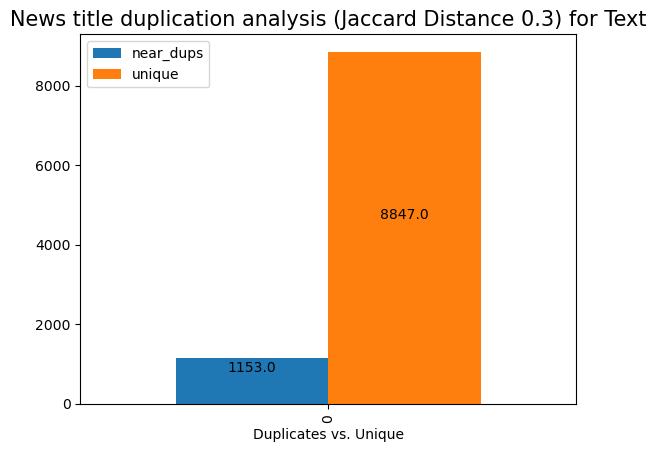

In [27]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis (Jaccard Distance 0.3) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [31]:
# Medium jaccard distance 0.5
jaccard_distance = 0.5

df_dups_text_50 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.trimmed_text').alias('text_A'),
            col('datasetB.trimmed_text').alias('text_B')) 

In [32]:
df_dups_txt_50 = df_dups_text_50

In [59]:
df_dups_txt_50 = df_dups_text_50
df_dups_text_50.cache()
# df_dups_text_50.limit(5).toPandas()

distCol,id_A,id_B,text_A,text_B
0.29166666666666663,5574,8744,{#サッカー好きな人フォローハッシ...,{Видео с хэштегом...
0.34615384615384615,5592,9748,{Video con l'hash...,{#ワンタッチの大切さハッシュタグ...
0.39473684210526316,6945,9038,{TikTok Creator C...,{TikTok Launches ...
0.16666666666666663,2945,5565,{Видео с хэштегом...,{Видео с хэштегом...
0.4666666666666667,2442,5051,{Видео с хэштегом...,{#anh_hướng_dẫn_h...
0.4482758620689655,898,6105,{#राजस्थानी_हो_तो...,{#ओसियां_जोधपुर T...
0.4285714285714286,4564,6592,{TikTok'ta #şeria...,{Видео с хэштегом...
0.31999999999999995,6596,7703,{#アメリカンビンテージハッシュタ...,{#dhaval_9486 Tik...
0.25806451612903225,5040,7133,{攻撃力100💛#猫のじんじゃあ...,{#TikTok3周年 #髪色チェ...
0.19047619047619047,6601,8216,{#今のところ次のハッシュタグに関...,{#はやりにのれないたいぷハッシュ...


In [30]:
records = df_hashed_text.count()
dups_50 = df_dups_text_50.select('id_A').distinct().count()
uniques = records - dups_50

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_50)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10000
Duplicate titles based on { 0.5 } jaccard distance:  2310
Unique titles based on { 0.5 } jaccard distance:  0.5 :  7690


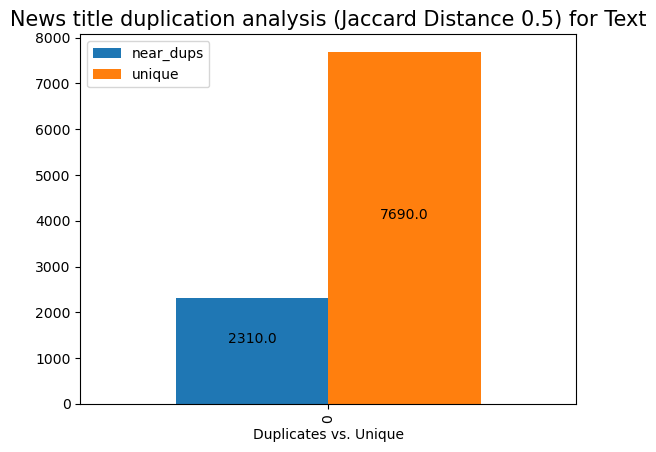

22/11/18 04:12:20 ERROR org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend: The YARN application has already ended! It might have been killed or the Application Master may have failed to start. Check the YARN application logs for more details.
22/11/18 04:12:20 ERROR org.apache.spark.SparkContext: Error initializing SparkContext.
org.apache.spark.SparkException: Unmanaged application application_1668743534540_0007 failed due to ApplicationMaster for attempt appattempt_1668743534540_0007_000001 timed out. Failing the application.
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.waitForApplication(YarnClientSchedulerBackend.scala:97)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.scala:64)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:220)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:579)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.sca

In [32]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_50], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis (Jaccard Distance 0.5) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [33]:
# High jaccard distance 0.7
jaccard_distance = 0.7

df_dups_text_70 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.trimmed_text').alias('text_A'),
            col('datasetB.trimmed_text').alias('text_B')) 

In [34]:
df_dups_txt_70 = df_dups_text_70

In [61]:
df_dups_txt_70 = df_dups_text_70
df_dups_text_70.cache()
# df_dups_text_70.limit(5).toPandas()

distCol,id_A,id_B,text_A,text_B
0.625,5159,5651,{After Life 3: Ho...,{Derby council wo...
0.653061224489796,3977,4526,{Sibling TikTok d...,{Air-Fried Banana...
0.5102040816326531,1167,6277,{Viral TikTok Vid...,"{Joe Jonas, Hayle..."
0.4444444444444444,2049,5568,{TikTok blocks ne...,{Video TikTok use...
0.48275862068965514,2249,6070,{ Grandpa’s text ...,{ Grandpa's text ...
0.5526315789473684,5407,9947,{Video: TikToker ...,{Video: What this...
0.6046511627906976,2998,7657,"{TikTok, TikTok: ...",{What is a nepo b...
0.48571428571428577,2998,3905,"{TikTok, TikTok: ...",{Video: Bobbi Bro...
0.5526315789473684,2998,7909,"{TikTok, TikTok: ...",{Video: TikToker ...
0.625,3994,5510,{TikTok was suppo...,{The Australian T...


In [38]:
# df_dups_txt_70.limit(5).toPandas()

In [65]:
records = df_hashed_text.count()
dups_70 = df_dups_text_70.select('id_A').distinct().count()
uniques = records - dups_70

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_70)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10000
Duplicate titles based on { 0.7 } jaccard distance:  6158
Unique titles based on { 0.7 } jaccard distance:  0.7 :  3842


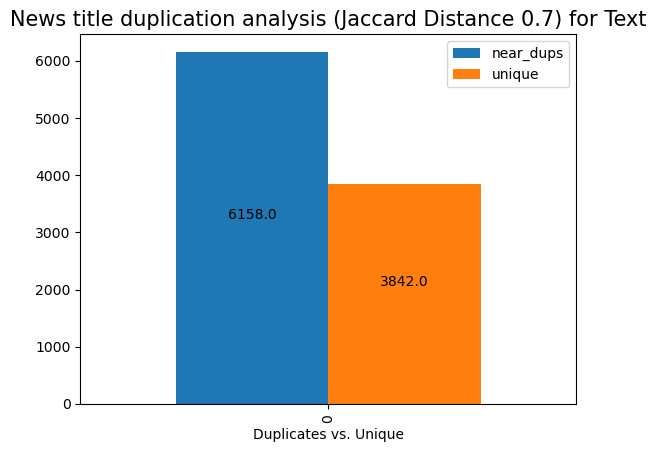

In [66]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_70], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis (Jaccard Distance 0.7) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Step 5. Compare thresholds side-by-side
#### Select all pairs of duplicate titles across jaccard similarities

In [35]:
df_dups_30_id = df_dups_txt_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_txt_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_txt_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

# print(df_dups_30_id.count())
# print(df_dups_50_id.count())
# print(df_dups_70_id.count())

In [36]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

# dups_combined.limit(5)

In [37]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

# dups_combined.limit(5)

In [38]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [39]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(#需要换名 Hashtag Videos on TikTokTikTokUpload Log inKeyboard shortcutsGo to previous videoGo to next videoLike video Mute / unmute video For YouFollowingLog in to follow creators, like videos, and view comments.Log inDiscoverAboutNewsroomStoreContactCareersByteDanceCreator DirectoryTikTok for GoodAdver,)","(“お風呂巡って交渉”編 #自称最年少tiktoker #りんか #1歳 #お風呂 #子どもあるある #おうちで過ごし隊TikTokUpload Log inKeyboard shortcutsGo to previous videoGo to next videoLike video Mute / unmute video For YouFollowingLog in to follow creators, like videos, and view comments.Log inDiscoverAboutNewsroomStoreContactCareersByteDanceC,)",Duplicate,Duplicate,Duplicate
1,"(#bilawal__ali Hashtag Videos on TikTokTikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 TikTokEn,)","(Videos con el hashtag #nomibilla751 en TikTokTikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 T,)",Duplicate,Duplicate,Duplicate
2,"(This video is from a private account. Follow this account to see their videos or visit TikTok to discover more trending videos. TikTokUpload Log inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inSuggested accountsAboutNewsroomStoreContactCareersByteDanceCreator ,)","(This video is from a private account. Follow this account to see their videos or visit TikTok to discover more trending videos. TikTokUpload Log inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inSuggested accountsAboutNewsroomStoreContactCareersByteDanceCreator ,)",Duplicate,Duplicate,Duplicate
3,"(#my_nme_is_anubhii🤓🤓 Hashtag Videos on TikTokTikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 T,)","(#220_😍 Hashtag Videos on TikTokTikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 TikTokEnglishEn,)",Duplicate,Duplicate,Duplicate
4,"(#пенелопакруз Hashtag Videos on TikTokTikTokUpload Log inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inDiscoverAboutNewsroomStoreContactCareersByteDanceCreator DirectoryTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyPrivacyCreator PortalCommunity Guidelines,)","(#ouwah Hashtag Videos on TikTokTikTokUpload Log inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inDiscoverAboutNewsroomStoreContactCareersByteDanceCreator DirectoryTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyPrivacyCreator PortalCommunity GuidelinesCopyrig,)",Duplicate,Duplicate,Duplicate
5,"(TikTok'ta #orhanküm Etiket İçeren VideolarTikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 TikT,)","(#これ私ですよハッシュタグに関するTikTokの動画TikTokLog inFor YouFollowingLog in to follow creators, like videos, and view comments.Log inAboutNewsroomStoreContactCareersByteDanceTikTok for GoodAdvertiseDevelopersTransparencyHelpSafetyTermsPrivacyCreate PortalCommunity GuidelinesCopyrightMore© 2021 TikTokEnglishEnglish,)",Duplicate,Duplicate,Duplicate
6,"(#splitdyechallenge Hashtag Videos on TikTokTikTokLog inFor YouFollowingLog in to follow creators,

22/11/18 05:34:02 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1668743534540_0024_01_000003 on host: hub-msca-bdp-dphub-students-zhiliny-sw-vdhb.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-11-18 05:34:02.119]Container killed on request. Exit code is 143
[2022-11-18 05:34:02.119]Container exited with a non-zero exit code 143. 
[2022-11-18 05:34:02.120]Killed by external signal
.
22/11/18 05:34:02 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 3 on hub-msca-bdp-dphub-students-zhiliny-sw-vdhb.c.msca-bdp-students.internal: Container from a bad node: container_1668743534540_0024_01_000003 on host: hub-msca-bdp-dphub-students-zhiliny-sw-vdhb.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-11-18 05:34:02.119]Container killed on request. Exit code is 143
[2022-11-18 05:34:02.119]Container exited with a non-zero exit code 143. 
[2022-11-18 05:34:02.120]Killed by external signal
.
22/11/18 0

#### From the result above, I conclude that the model with jaccard distance of 0.3 is the best

### Build a histogram showing the overall distribution of “near-duplication”---Text

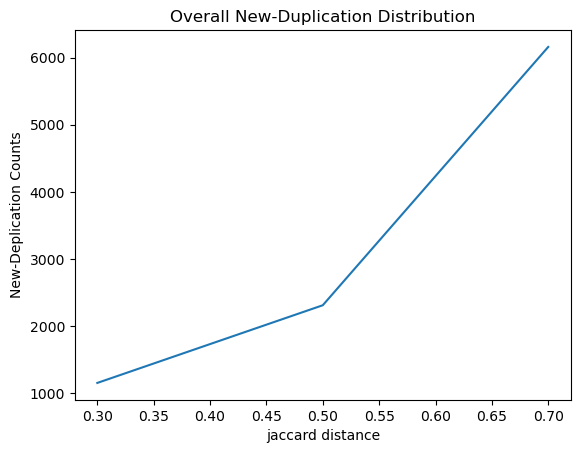

22/11/18 05:35:39 ERROR org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend: The YARN application has already ended! It might have been killed or the Application Master may have failed to start. Check the YARN application logs for more details.
22/11/18 05:35:39 ERROR org.apache.spark.SparkContext: Error initializing SparkContext.
org.apache.spark.SparkException: Unmanaged application application_1668743534540_0022 failed due to ApplicationMaster for attempt appattempt_1668743534540_0022_000001 timed out. Failing the application.
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.waitForApplication(YarnClientSchedulerBackend.scala:97)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.scala:64)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:220)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:579)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.sca

In [40]:
import matplotlib.pyplot as plt
duptitle70= 6158
duptitle50= 2310
duptitle30= 1153

xaxis = [0.3,0.5,0.7]
plt.plot(xaxis,[duptitle30,duptitle50,duptitle70])
plt.title('Overall New-Duplication Distribution')
plt.xlabel('jaccard distance')
plt.ylabel('New-Deplication Counts')
plt.show()